# Visualizing batch effects with t-SNE.

I tried to visualize inherent batch effects of the data with t-SNE. Since each image is a 512\*512\*6 = 1572864-dimensional vector, separately using all of the pixels as an element of a vector makes t-SNE computation too intensive. To overcome it, I simply took average of the pixel intensities for each of the six channels given for an image, therefore handled a six-dimensional vector for each image.

Another thing to note is that as the objective of this kernel is to visualize the batch effects, I only exploited positive and negative control-images to exclude siRNA-related effects.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image as image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

import tqdm

!pip install opentsne
from openTSNE.sklearn import TSNE
# Any results you write to the current directory are saved as output.

['test', 'pixel_stats.csv', 'sample_submission.csv', 'test.csv', 'recursion_dataset_license.pdf', 'test_controls.csv', 'train_controls.csv', 'train.csv', 'train']
     |████████████████████████████████| 839kB 4.7MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/82/66/5c/ff15e5b7c0fd8cf975379e972826fd51201ba12701688656c3
  Stored in directory: /tmp/.cache/pip/wheels/c2/dc/94/2055c891994f758c6453808c69b6ce852672e5e9c426c56717
Successfully built opentsne pynndescent


In [2]:
train_controls = pd.read_csv('../input/train_controls.csv')
test_controls = pd.read_csv('../input/test_controls.csv')
train_controls['cell_line'] = [v[0] for v in train_controls.id_code.str.split('-')]
test_controls['cell_line'] = [v[0] for v in test_controls.id_code.str.split('-')]

train_controls.shape, test_controls.shape

((4097, 7), (2246, 7))

In [3]:
train_controls.head(3)

,id_code,experiment,plate,well,sirna,well_type,cell_line
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1138,negative_control,HEPG2
1,HEPG2-01_1_C03,HEPG2-01,1,C03,1109,positive_control,HEPG2
2,HEPG2-01_1_C07,HEPG2-01,1,C07,1121,positive_control,HEPG2


In [4]:
test_controls.head(3)

,id_code,experiment,plate,well,sirna,well_type,cell_line
0,HEPG2-08_1_B02,HEPG2-08,1,B02,1138,negative_control,HEPG2
1,HEPG2-08_1_C03,HEPG2-08,1,C03,1137,positive_control,HEPG2
2,HEPG2-08_1_C07,HEPG2-08,1,C07,1120,positive_control,HEPG2


Let's extract IDs of control siRNAs that are present in all of the plates.

In [5]:
positive_sirnas = train_controls[train_controls.well_type == 'positive_control'].sirna.unique()
negative_sirna = train_controls[train_controls.well_type == 'negative_control'].sirna.unique()[0]

In [6]:
negative_sirna

1138

In [7]:
positive_sirnas

array([1109, 1121, 1126, 1118, 1116, 1110, 1113, 1114, 1137, 1120, 1117,
       1135, 1115, 1131, 1125, 1127, 1123, 1108, 1122, 1132, 1124, 1134,
       1128, 1130, 1136, 1133, 1112, 1129, 1119, 1111])

In [8]:
len(positive_sirnas)

30

In [9]:
def get_image_file(experiment, plate, well, channel, site=1, train=True):
    train_path = f'../input/train/{experiment}/Plate{plate}/{well}_s{site}_w{channel}.png'
    test_path = f'../input/test/{experiment}/Plate{plate}/{well}_s{site}_w{channel}.png'
    if os.path.exists(train_path):
        return train_path
    else:
        return test_path
    
def get_image_nparray(experiment, plate, well, channel, site=1, train=True):
    img = np.array(image.open(get_image_file(experiment, plate, well, channel, site, train)))
    return img.reshape(-1)

In [10]:
data = []
for i, row in tqdm.tqdm(train_controls.iterrows(), total=len(train_controls)):
    v = []
    for channel in range(1, 7):
        # Take means of pixel intensities.
        v.append(get_image_nparray(experiment=row.experiment, plate=row.plate, well=row.well, channel=channel).mean())
    data.append(v)
data = np.array(data)

100%|██████████| 4097/4097 [02:32<00:00, 26.88it/s]


In [11]:
data.shape

(4097, 6)

In [12]:
embedding = TSNE().fit_transform(data)

/opt/conda/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/conda/lib/python3.6/site-packages/pynndescent/rp_trees.py", line 133:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/opt/conda/lib/python3.6/site-packages/pynndescent/pynndescent_.py:177: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/conda/lib/python3.6/site-packages/pynndescent/utils.py", line 79:

### Add column `cell_line` to the metadata.

In [13]:
train_controls.head(3)

,id_code,experiment,plate,well,sirna,well_type,cell_line
0,HEPG2-01_1_B02,HEPG2-01,1,B02,1138,negative_control,HEPG2
1,HEPG2-01_1_C03,HEPG2-01,1,C03,1109,positive_control,HEPG2
2,HEPG2-01_1_C07,HEPG2-01,1,C07,1121,positive_control,HEPG2


In [14]:
train_controls.cell_line.unique()

array(['HEPG2', 'HUVEC', 'RPE', 'U2OS'], dtype=object)

# Visualize!

# Visualizing batch effects for cell line RPE.

Clear distinction between RPE-01~03 and RPE-04~07 is shown.

There are 7 experiments.


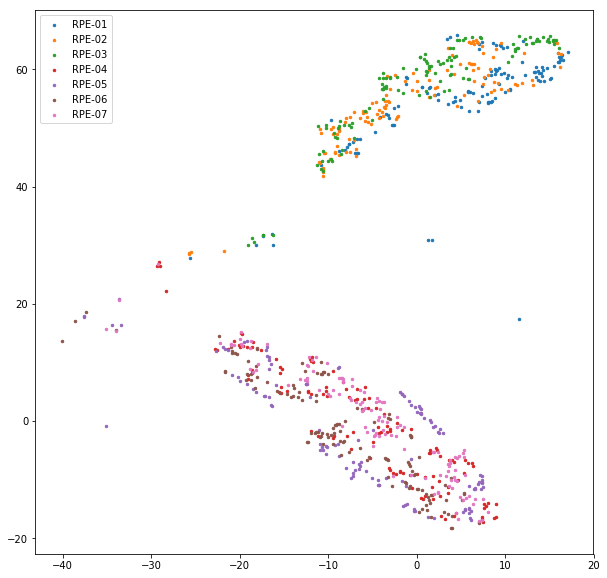

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
print('There are %d experiments.' % len(train_controls[train_controls.cell_line.values == 'RPE'].experiment.unique()))
for exp in train_controls.experiment.unique():
    mask = (train_controls.experiment.values == exp) & (train_controls.cell_line.values == 'RPE')
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)

ax.legend();

# Visualizing batch effects for cell line HEPG2.

Interestingly, again, HEPG2-01~03, HEP-04, and HEPG2-05~07 are clustered toghther.

There are 7 experiments.


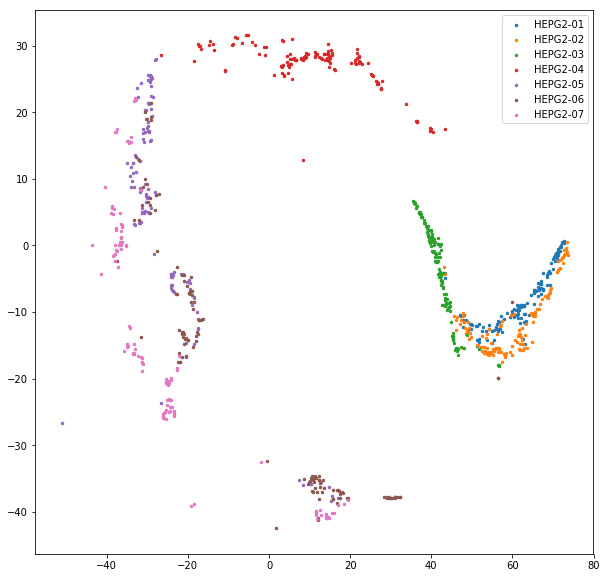

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
print('There are %d experiments.' % len(train_controls[train_controls.cell_line.values == 'HEPG2'].experiment.unique()))

for exp in train_controls.experiment.unique():
    mask = (train_controls.experiment.values == exp) & (train_controls.cell_line.values == 'HEPG2')
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)

ax.legend();

# Visualizing batch effects for cell line HUVEC.

As there are 16 different experiments for HUVEC cell lines, it is difficult to visualize with discrete color maps.

Instead, it is displayed with a continuous color map such that mapped color gets darker as experiment IDs change from 01 to 16.

Again we can notice that the experiments with closer experiment IDs are clustered together.

There are 16 experiments.


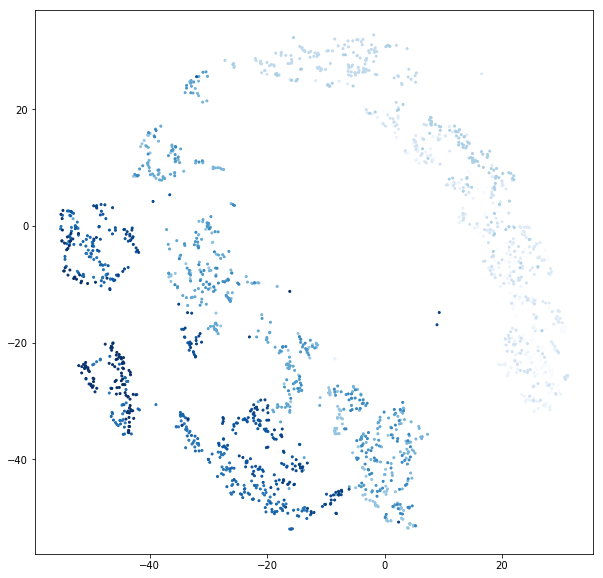

In [17]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

mask = (train_controls.cell_line.values == 'HUVEC')
print('There are %d experiments.' % len(train_controls[mask].experiment.unique()))
ax.scatter(embedding[mask, 0], embedding[mask, 1], c=[float(v[1]) / 16 for v in train_controls[mask].experiment.str.split('-')], cmap=plt.cm.Blues, s=4);

# Visualizing batch effects for cell line U2OS.

There are three U2OS cell line experiments. We can notice that each experiment can be more or less separated in t-SNE space, but there were no apparent inter-experiment clustering.

There are 3 experiments.


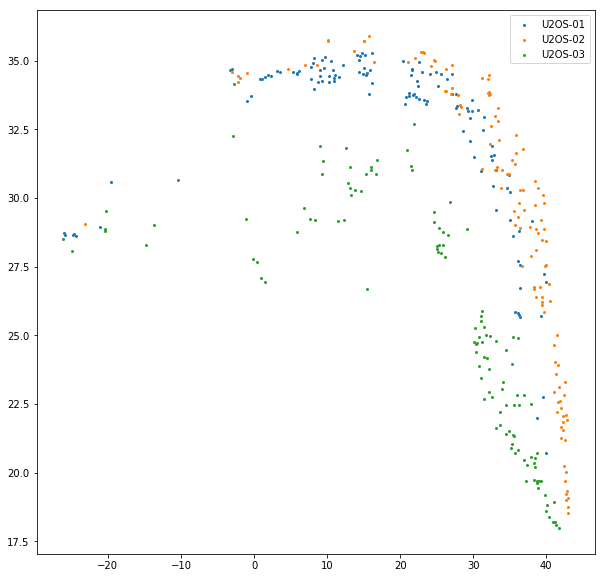

In [18]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
print('There are %d experiments.' % len(train_controls[train_controls.cell_line.values == 'U2OS'].experiment.unique()))

for exp in train_controls.experiment.unique():
    mask = (train_controls.experiment.values == exp) & (train_controls.cell_line.values == 'U2OS')
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=4)

ax.legend();

# Cell line-based coloring.

There are 33 experiments.


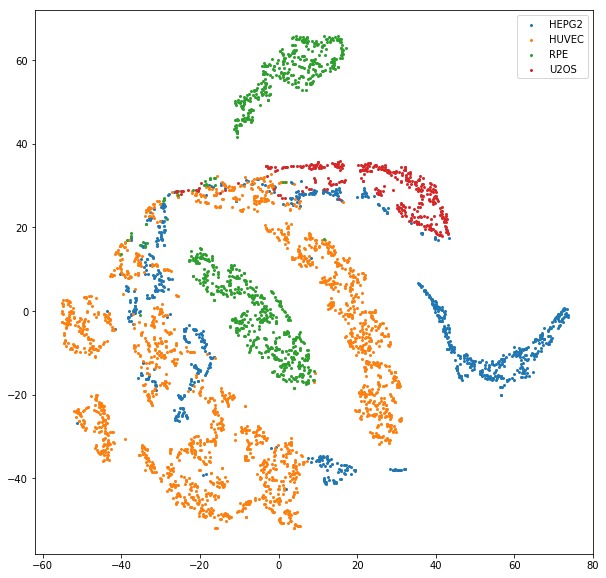

In [19]:
print('There are %d experiments.' % len(train_controls.experiment.unique()))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for cl in train_controls.cell_line.unique():
    mask = (train_controls.cell_line.values == cl)
    ax.scatter(embedding[mask, 0], embedding[mask, 1], label=cl, s=4)

ax.legend()


# siRNA-based coloring.

We hope that images to be clustered according to the treated siRNAs. Unfortunately, but as expected, we could not identify any distinct clusters that reflects the type of treated siRNA.

For the sake of visualization, only ten siRNAs are shown.

There are 33 experiments.


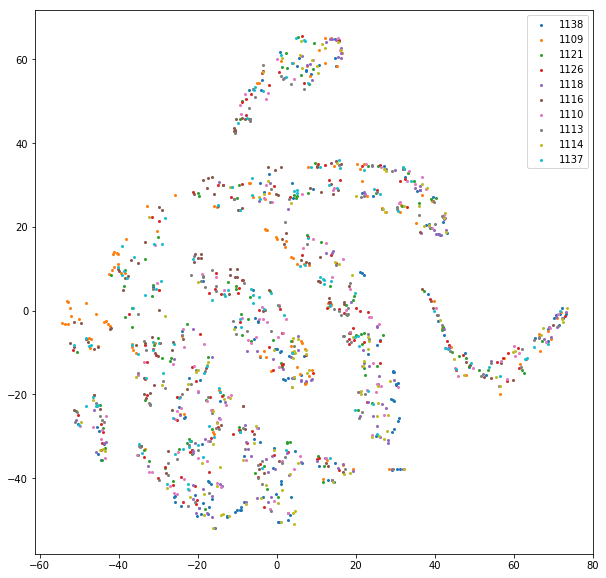

In [20]:
print('There are %d experiments.' % len(train_controls.experiment.unique()))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
for si in train_controls.sirna.unique()[:10]:
    mask = (train_controls.sirna.values == si)
    ax.scatter(embedding[mask, 0], embedding[mask, 1], label=si, s=4)

ax.legend();

# Marking negative controls.

Perhaps one of the intuitive way to envision the effect of batch effect (or plate effect) removal is to make images without any siRNA treatment clustered in the latent space where the images are distributed.

Before that, let's see how the negative control-images are distributed without any correction for batch effect.

It was expected that they suffer from severe experiment-wise batch effects, but also, 

There are 33 experiments.


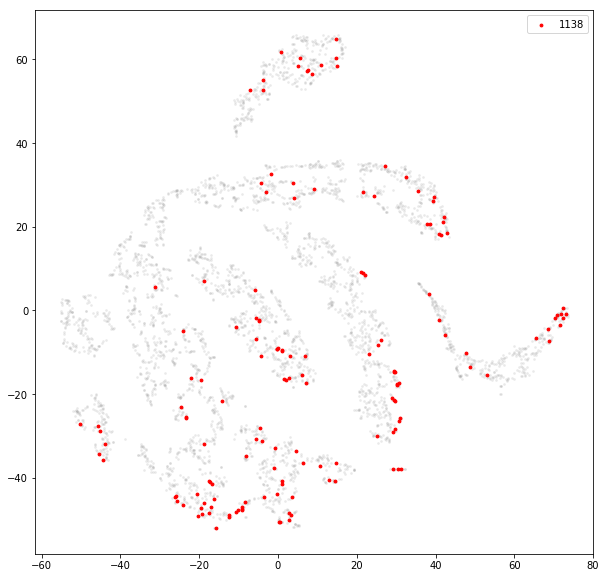

In [21]:
print('There are %d experiments.' % len(train_controls.experiment.unique()))

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

mask = (train_controls.sirna.values == 1138)
ax.scatter(embedding[:, 0], embedding[:, 1], alpha=0.11, color='grey', s=3)
ax.scatter(embedding[mask, 0], embedding[mask, 1], label=1138, s=8, color='red')

ax.legend();

# Visualizing test controls along with train controls.

Seeing which test experiments has similar batch effects with which train experiments may give us some insight about how to deal with batch effects in test dataset.

In [22]:
test_controls['cell_line'] = [v[0] for v in test_controls.id_code.str.split('-')]
controls = pd.concat([train_controls, test_controls])

In [23]:
controls.shape

(6343, 7)

In [24]:
data = []
for i, row in tqdm.tqdm(controls.iterrows(), total=len(controls)):
    v = []
    for channel in range(1, 7):
        # Take means of pixel intensities.
        v.append(get_image_nparray(experiment=row.experiment, plate=row.plate, well=row.well, channel=channel).mean())
    data.append(v)

data = np.array(data)

100%|██████████| 6343/6343 [03:32<00:00, 29.82it/s]


In [25]:
embedding = TSNE().fit_transform(data)

/opt/conda/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/conda/lib/python3.6/site-packages/pynndescent/pynndescent_.py", line 38:
    @numba.njit(parallel=True, fastmath=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  self.func_ir.loc))
/opt/conda/lib/python3.6/site-packages/numba/compiler.py:588: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../opt/conda/lib/python3.6/site-packages/pynndescent/pynndescent_.py", l

# [With test controls] Visualizing batch effects for cell line RPE.

There are 11 experiments.


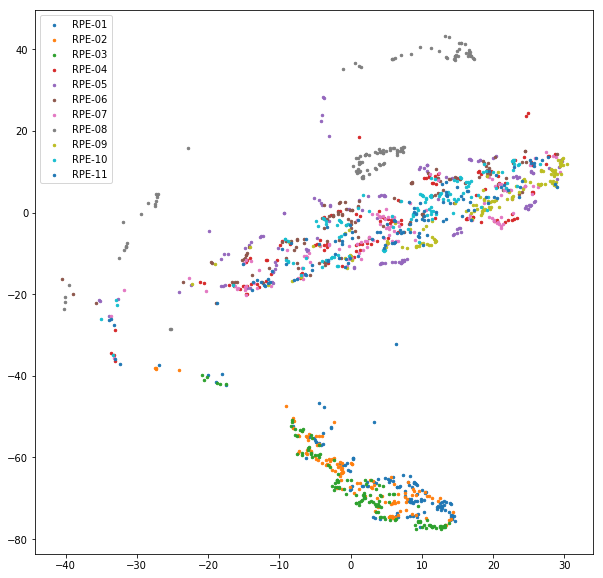

In [26]:
CELL_LINE = 'RPE'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

unique_exps = controls[controls.cell_line.values == CELL_LINE].experiment.unique()
print('There are %d experiments.' % len(unique_exps))

for exp in unique_exps:
    mask = (controls.experiment.values == exp) & (controls.cell_line.values == CELL_LINE)
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)

ax.legend();

There are 11 experiments.


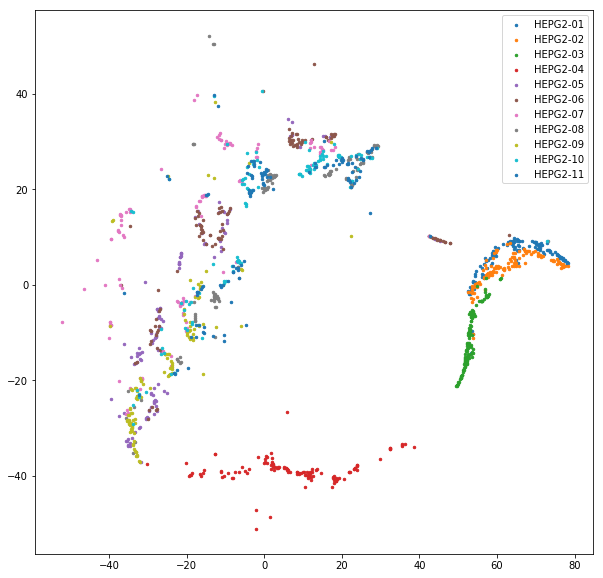

In [27]:
CELL_LINE = 'HEPG2'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

unique_exps = controls[controls.cell_line.values == CELL_LINE].experiment.unique()
print('There are %d experiments.' % len(unique_exps))

for exp in unique_exps:
    mask = (controls.experiment.values == exp) & (controls.cell_line.values == CELL_LINE)
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)

ax.legend();

# [With test controls] Visualizing batch effects for cell line HUVEC.

There are 24 experiments.


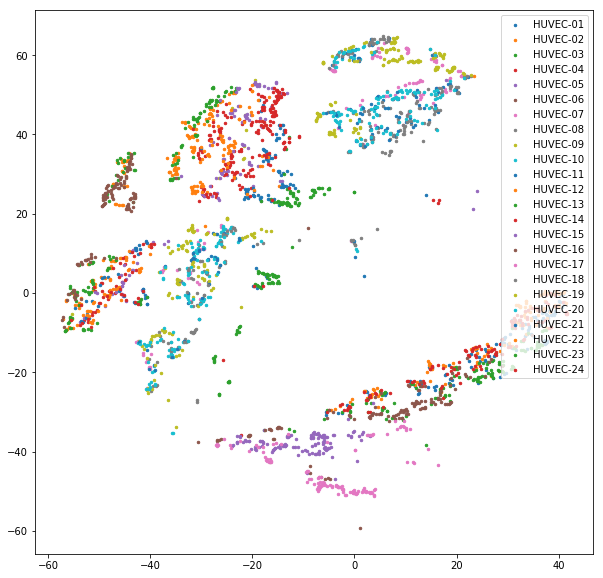

In [28]:
CELL_LINE = 'HUVEC'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

unique_exps = controls[controls.cell_line.values == CELL_LINE].experiment.unique()
print('There are %d experiments.' % len(unique_exps))

for exp in unique_exps:
    mask = (controls.experiment.values == exp) & (controls.cell_line.values == CELL_LINE)
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)

ax.legend();

# [With test controls] Visualizing batch effects for cell line U2OS.

There are 5 experiments.


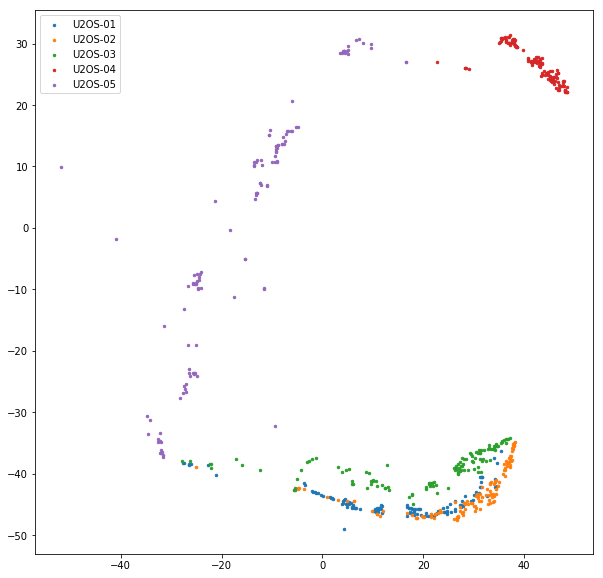

In [29]:
CELL_LINE = 'U2OS'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

unique_exps = controls[controls.cell_line.values == CELL_LINE].experiment.unique()
print('There are %d experiments.' % len(unique_exps))

for exp in unique_exps:
    mask = (controls.experiment.values == exp) & (controls.cell_line.values == CELL_LINE)
    if sum(mask) != 0:
        ax.scatter(embedding[mask, 0], embedding[mask, 1], label=exp, s=6)

ax.legend();